# Naive Risk Budgeting Strategies between the PSP and GHP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import edhec_risk_kit as erk

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def bt_mix(r1, r2, allocator, **kwargs):
    '''
    Runs a back test (simulation) of allocating between two sets of returns,
    r1 and r2 are T x N DataFrames or returns where T is the time step index and N is the number of scenarios.
    allocator is a fuction that takes two sets of returns and allocator specific parameters, and produces
    an allocation to the first portfolio (the rest of the money is invested in GHP) as a T x 1 DataFrame
    Returns a T x N DataFrame of the resulting N portfolio scenarios
    '''
    if not r1.shape == r2.shape:
        raise ValueError('r1 and r2 need to be the same shape.')
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError('Allocator returned weights that dont match r1')
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [3]:
def fixedmix_allocator(r1, r2, w1, **kwargs):
    '''
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarions
    PSP and GHP are T x N DataFrames that represent the returns of the PSP and GHP such that:
        each column is a scenario
        each row is the price for a timestamp
    Returns a T x N DataFrame of PSP weights
    '''
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)

In [4]:
rates, zc_prices = erk.cir(10, 500, b=0.03, r_0=0.03)
price_10 = erk.bond_price(10, 100, .05, 12, rates)
price_30 = erk.bond_price(30, 100, .05, 12, rates)
rets_30 = erk.bond_total_return(price_30, 100, .05, 12)
rets_10 = erk.bond_total_return(price_10, 100, .05, 12)
# testing mix
rets_bonds = erk.bt_mix(rets_10, rets_30, erk.fixedmix_allocator, w1=.6)
mean_rets_bonds = rets_bonds.mean(axis=1)
erk.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.0357,0.003765,0.305133,3.580489,-0.001256,-0.00083,1.473277,-0.000162


In [5]:
price_eq = erk.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [6]:
rets_7030b = bt_mix(rets_eq, rets_bonds, allocator=erk.fixedmix_allocator, w1=0.7)
rets_7030_mean = rets_7030b.mean(axis=1)
erk.summary_stats(pd.DataFrame(rets_7030_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.059335,0.004868,0.530013,2.999853,-0.002732,-0.002445,5.865086,0.0


In [7]:
summaries = erk.summary_stats(rets_7030b)

In [8]:
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.068816,0.114871,-0.312460,3.815734,0.050537,0.070773,0.328745,-0.252410
1,0.009149,0.106249,0.189299,2.989424,0.047358,0.059197,-0.191127,-0.169916
2,0.096585,0.110509,-0.150867,3.321554,0.045181,0.064310,0.586321,-0.199711
3,0.099985,0.125441,0.008951,2.436262,0.051015,0.062083,0.542873,-0.229833
4,0.035807,0.109658,0.276545,3.042805,0.045872,0.055516,0.051407,-0.301845


In [9]:
summaries.mean()

Annualized Return          0.053913
Annualized Vol             0.106961
Skewness                   0.000634
Kurtosis                   2.934246
Cornish-Fisher VaR (5%)    0.045764
Historic CVaR (5%)         0.057763
Sharpe Ratio               0.218730
Max Drawdown              -0.209513
dtype: float64

In [10]:
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30')
], axis=1)

,FI,Eq,70/30
mean,1.38234,1.960249,1.776622
std,0.11245,0.946915,0.598383
p_breach,NaN,0.046000,0.008000
e_short,NaN,0.089738,0.038372
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


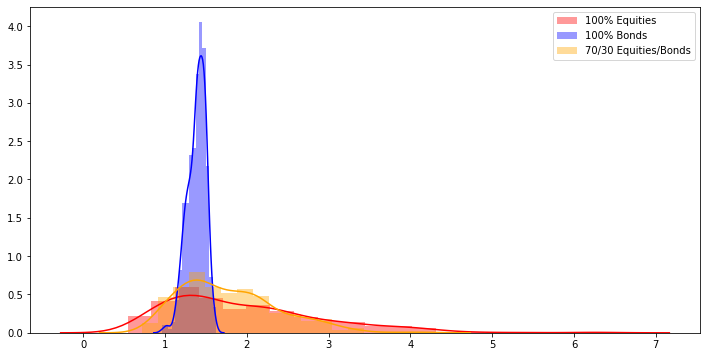

In [11]:
plt.figure(figsize=(12, 6))
sns.distplot(erk.terminal_values(rets_eq), color='red', label='100% Equities')
sns.distplot(erk.terminal_values(rets_bonds), color='blue', label='100% Bonds')
sns.distplot(erk.terminal_values(rets_7030b), color='orange', label='70/30 Equities/Bonds')
plt.legend()

# Glide Paths for Allocation

In [12]:
rets_g8030 = erk.bt_mix(rets_eq, rets_bonds, allocator=erk.glidepath_allocator, start_glide=.80, end_glide=.20)
pd.concat([
    erk.terminal_stats(rets_bonds, name='FI'),
    erk.terminal_stats(rets_eq, name='Eq'),
    erk.terminal_stats(rets_7030b, name='70/30'),
    erk.terminal_stats(rets_g8030, name='Glide 80 to 20')
], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.38234,1.960249,1.776622,1.660895
std,0.11245,0.946915,0.598383,0.435769
p_breach,NaN,0.046000,0.008000,NaN
e_short,NaN,0.089738,0.038372,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN
